In [1]:
%cd /home/josh/PycharmProjects/Muon_magnets

/home/josh/PycharmProjects/Muon_magnets


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import time

import modules.functions as func
from modules.muon import Muon
from modules.ensemble import Ensemble

from modules.multi_process import MP_fields
from modules.model_equations import static_GKT

%matplotlib inline

## Single muon relaxation function
A single muon has an small field applied in the +ve x direction

In [29]:
muon = Muon(lifetime=Muon.TIME_SCALE)
print(muon.__dict__)
print(Muon.GYRO_RATIO)

{'lifetime': 0.0001, 'spin_dir': array([ 0,  0, -1]), 'phase': 0, 'loc': array([0, 0, 0])}
851615000.0


In [64]:
muon.field = np.array([0.2e-3, 0, 0])  # Set field experienced by muon to +ve x dir

lifetime_polarisation = muon.full_relaxation(muon.field)  # Get the polarisation of the muon as a function of time

peaks = Muon.TIME_ARRAY[np.where(lifetime_polarisation[:-1] >= 0.99999)]  # Crude peak detetction. Verified by visual inspection

av_period = sum(np.diff(peaks))/(len(peaks)) # Find period of osciallation
av_freq = 1/av_period
calc_field = 1e3*av_freq/(Muon.GYRO_RATIO)  # Field in mT

print(f"Calculated frequency: {av_freq:.2e} Hz")
print(f"Field calculated from frequency: {calc_field:.7f} mT")
print(f"Angle between field and inital spin direction: {np.rad2deg(muon.spin_field_angle)} deg")

Calculated frequency: 4.07e+04 Hz
Field calculated from frequency: 0.0477418 mT
Angle between field and inital spin direction: 90.0 deg


The polarisation is found using:
$$ \sigma (t) = cos^2(\theta) + sin^2(\theta)~cos(\gamma_{\mu} |H| t) $$
Where $\theta$ is the angle between the spin direction and the field, $\gamma_{\mu}$ is the muon gyro ratio, $|H|$ is the magnitude of the field and it is taken as a function of $t$

Text(0.5, 1.0, 'Polarisation for single muon in 0.20 mT field (spin: [0, 0, -1])')

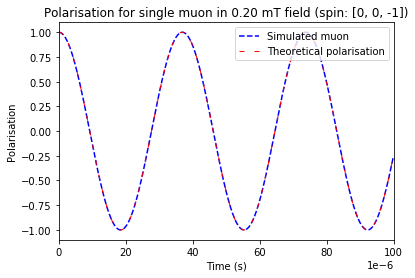

In [42]:
theta = muon.spin_field_angle
B = func.get_mag(muon.field)
theoretical_polar = np.cos(theta) ** 2 + (np.sin(theta) ** 2) * np.cos(Muon.GYRO_RATIO * B * Muon.TIME_ARRAY)

fig, ax = plt.subplots()
ax.plot(Muon.TIME_ARRAY, lifetime_polarisation, "b", linestyle="--", label="Simulated muon")
ax.plot(Muon.TIME_ARRAY, theoretical_polar, "r", linestyle=(0, (5, 10)), lw=1, label="Theoretical polarisation")

plt.legend(loc="upper right")
ax.ticklabel_format(axis="x", style="sci", scilimits=(-6, -6))
ax.set_xlim(0, Muon.TIME_SCALE)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Polarisation")
ax.set_title(f"Polarisation for single muon in {func.get_mag(muon.field)*1000:.2f} mT field (spin: {list(muon.spin_dir)})")

The calculated field is incorrect however the plot of polarisation against time appears to match the expected value. Using a field magnitude of 0.2 mT results in a calculated field value of 0.0477 mT

The period of oscillation is calculated from the peak-to-peak separation.
$$\omega_l = \gamma_{\mu} |B|$$
The above can be rearanged to calculate B from $\omega_l$ (which is calculated), and $\gamma$ which is a constant.

#### Calculate overall relaxation function for an ensemble of muons

An ensemble of 10,000 particles are each assigned a random magnetic field to "expereince" to simulate a zero-field relaxation function.
The x, y, z components of the magnetic field are drawn from a guassian distribution (mean = 0, std = 10e-6)

The well known static guassian kubo-toyabe function is recovered under these conditions implying that the simulated muons behave in the expected way.

$$G_z(t) = \dfrac{1}{3} + \dfrac{2}{3}(1-\Delta^2 t^2)exp^{(-0.5 \Delta^2 t^2)}$$

In [6]:
# Create an ensemble of muons

FIELD_WIDTH = 100e-6
particles = Ensemble(N=10_000)
particles.random_fields(width=FIELD_WIDTH)

# Calculate each particles relaxation over time and the ensemble average
particles.set_relaxations()

Saving pickle to data//ensemble_obj.pickle


Below is a plot of the average of the ensembles relaxation functions. 

Text(0.35, 0.45, '1/3 tail')

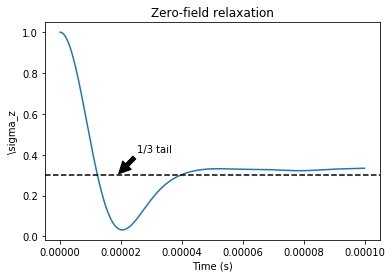

In [52]:
plt.figure()
plt.plot(Muon.TIME_ARRAY, particles.overall_relax)
plt.axhline(0.3, linestyle="--", c="k")
plt.title("Zero-field relaxation")
plt.xlabel("Time (s)")
plt.ylabel("\sigma_z")
ax.ticklabel_format(axis="x", style="sci", scilimits=(-6, -6))
plt.annotate("1/3 tail", xy=(0.3, 0.37), xytext=(0.35, 0.45), xycoords="figure fraction",
             arrowprops=dict(facecolor='black', shrink=0.05))

### Verify result

The static guassian kubo-toyabe is curve fitted against the simulation result to verify the result.

The random fields are also shown below to demonstrate the guassian distributio and the distribution of field magnitudes. The values for the field distribution are copied from https://www.isis.stfc.ac.uk/Pages/2005-relaxation-functions-rc7912.pdf

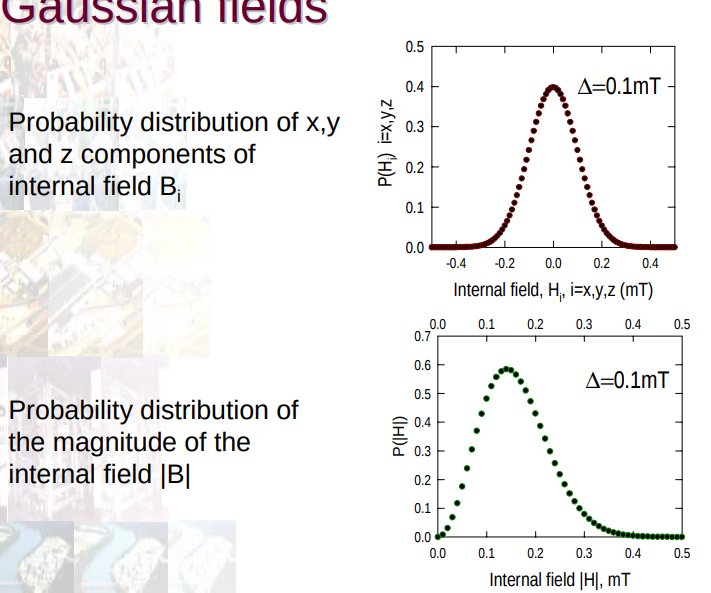

Calculated width: 9.92e-05 +- 1.84e-15


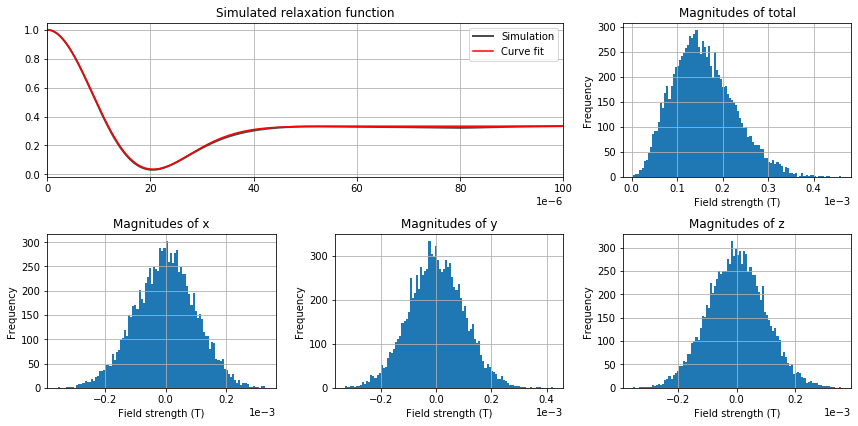

In [8]:
particles.plot_relax_fields(save=False)

## Testing longitudinal external field
An external field along the z direction (muon initial polarisation direction) in addition to the random guassian fields.

In [27]:
# Create ensemble
fields = [1e-4, 2e-4, 3.5e-4, 5e-4, 1e-3, 5e-3]
particle_list = [Ensemble(N=10_000) for _ in range(len(fields))]

particles_dict = {}

for field, group in zip(fields, particle_list):
    ext_field = np.array([0, 0, float(field)])
    
    group.random_fields(width=100e-6)
    group.add_field(ext_field)
    group.set_relaxations()

Saving pickle to data//ensemble_obj.pickle
Saving pickle to data//ensemble_obj.pickle
Saving pickle to data//ensemble_obj.pickle
Saving pickle to data//ensemble_obj.pickle
Saving pickle to data//ensemble_obj.pickle
Saving pickle to data//ensemble_obj.pickle


Text(0.5, 1.0, 'External field in ')

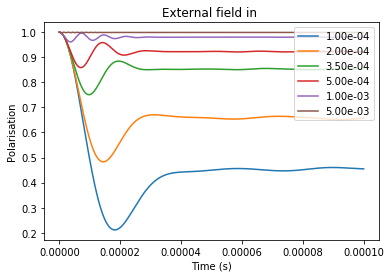

In [28]:
fig, ax = plt.subplots()
for field, group in zip(fields, particle_list):
    ax.plot(Muon.TIME_ARRAY, group.overall_relax, label=f"{func.get_mag(field):.2e}")

plt.legend(loc="upper right")
plt.xlabel("Time (s)")
plt.ylabel("Polarisation")
plt.title("External field in ")